In [113]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [114]:
import pandas as pd
import utils

TS = 48

samples = list(range(201, 211)) #[201, 202, 203]
data_train, df_date = utils.load_data(samples, TS)

(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [115]:
class A2C(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(A2C, self).__init__()
        self.num_actions = n_actions
        
        self.layer1_actor = nn.Linear(n_observations, 256)
        self.layer1_critic = nn.Linear(n_observations, 256)
        
        self.layer2_actor = nn.Linear(256, 128)
        self.layer2_critic = nn.Linear(256, 128)
        
        self.layer3_actor = nn.Linear(128, n_actions)
        self.layer3_critic = nn.Linear(128, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        px = F.relu(self.layer1_actor(x))
        px = F.relu(self.layer2_actor(px))
        policy_dist = F.softmax(self.layer3_actor(px), dim=-1)

        vx = F.relu(self.layer1_critic(x))
        vx = F.relu(self.layer2_critic(vx))
        value = self.layer3_critic(vx)
        
        return value, policy_dist

In [116]:
BATCH_SIZE = 128
GAMMA = 1
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
a2c_net = A2C(n_observaons, n_actions).to(device)
optimizer = optim.Adam(a2c_net.parameters(), lr=1e-4)

7


In [118]:
all_lengths = []
average_lengths = []
all_rewards = []
all_sc_ss = []

entropy_term = 0
    
num_episodes = len(data_train)

for i_episode in range(num_episodes):

    env = utils.ENV_BATT(data_train[i_episode%len(data_train)])
    state = env.reset()    

    log_probs = []
    values = []
    rewards = []
    
    total_export = 0.0
    total_pv = 0.0
    total_ld = 0.0
        
    for i in range(env.data_env.shape[0]):
        value, policy_dist = a2c_net.forward(state)
        value = value.detach().numpy()[0]
        dist = policy_dist.detach().numpy()
        action = np.random.choice(n_actions, p=np.squeeze(dist))
        
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(dist * np.log(dist + 1e-10))
        new_state, reward, done = env.step(action)

        rewards.append(reward.squeeze(0))
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        total_export += state.numpy()[5] if state.numpy()[5] < 0 else 0
        total_pv += state.numpy()[0]
        total_ld += state.numpy()[1]

        # if done:
        if (i + 1) % TS == 0:
            Qval, _ = a2c_net.forward(new_state)
            Qval = Qval.detach().numpy()[0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(i)
            average_lengths.append(np.mean(all_lengths[-10:]))
            # print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(i_episode, np.sum(rewards), i, average_lengths[-1]))

            # compute Q values
            Qvals = np.zeros_like(values)
            for t in reversed(range(len(rewards))):
                Qval = rewards[t] + GAMMA * Qval
                Qvals[t] = Qval

            #update actor critic
            values = torch.FloatTensor(values)
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs)
            
            advantage = Qvals - values
            actor_loss = -(log_probs * advantage).mean()
            critic_loss = 0.05 * advantage.pow(2).mean()
            ac_loss = actor_loss + critic_loss - 0.001 * entropy_term
            print(actor_loss, critic_loss, 0.001*entropy_term)

            optimizer.zero_grad()
            ac_loss.backward()
            print(ac_loss.item())
            optimizer.step()

            log_probs = []
            values = []
            rewards = []

    sc = (total_pv + total_export)/total_pv
    ss = (total_pv + total_export)/total_ld
    all_sc_ss.append([sc, ss])
    print('sc and ss', sc, ss)


tensor(5.3481, grad_fn=<NegBackward0>) tensor(8.4548) 0.02284049528837204
13.780029296875
tensor(5.5248, grad_fn=<NegBackward0>) tensor(12.1168) 0.04256343901157379
17.598960876464844
tensor(7.2546, grad_fn=<NegBackward0>) tensor(16.2362) 0.05997912222146988
23.430809020996094
tensor(4.3369, grad_fn=<NegBackward0>) tensor(16.2412) 0.07905457457900048
20.49907112121582
tensor(6.6255, grad_fn=<NegBackward0>) tensor(15.5653) 0.09738880148530006
22.093496322631836
tensor(5.3624, grad_fn=<NegBackward0>) tensor(15.7557) 0.11487899500131607
21.003143310546875
tensor(6.7606, grad_fn=<NegBackward0>) tensor(15.7757) 0.13321710270643233
22.403034210205078
tensor(6.6498, grad_fn=<NegBackward0>) tensor(14.5401) 0.14933625796437264
21.04058265686035
tensor(2.9943, grad_fn=<NegBackward0>) tensor(13.6167) 0.16145837658643722
16.4495906829834
tensor(4.5771, grad_fn=<NegBackward0>) tensor(13.2468) 0.17113653077185154
17.65277862548828
tensor(0.5106, grad_fn=<NegBackward0>) tensor(12.0416) 0.178507565662

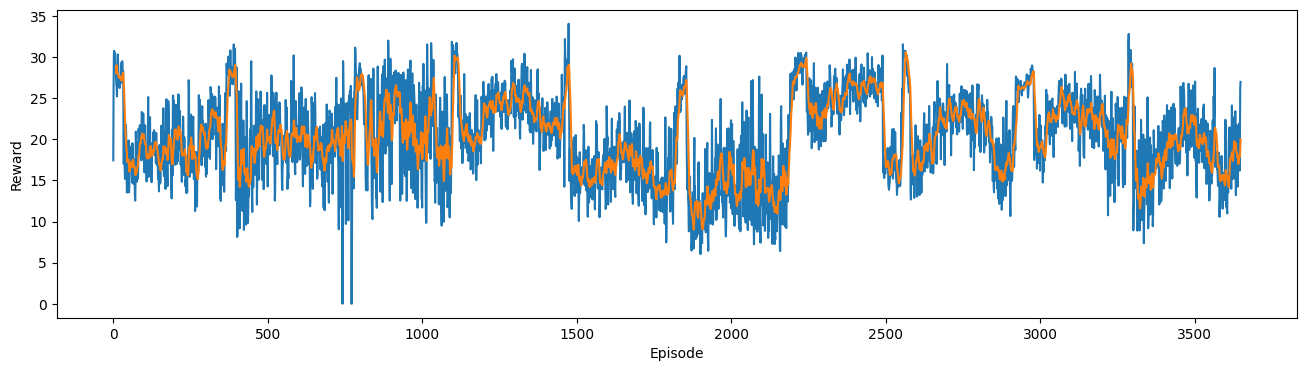

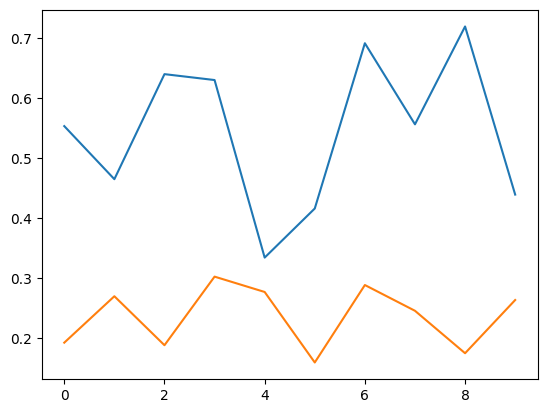

In [119]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.figure(figsize=(16, 4))
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(np.array(all_sc_ss)[:, 0])
plt.plot(np.array(all_sc_ss)[:, 1])
plt.show()

In [120]:
data_test, df_date = utils.load_data([1], TS)
data_test = data_test[0]

(17520, 2)


In [121]:
capacity = 50.
env = utils.ENV_BATT(data_test, capacity)
state = env.reset()    
state = torch.tensor(state).unsqueeze(0)

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        _, logits = a2c_net.forward(state)
        # prob = F.softmax(logits, dim=1).data
        action = torch.argmax(logits, dim=1).numpy()[0]
        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1472/849261814.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


                      PV     LD         BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.855   5.000000  0.0  0.855  0.000000
2012-07-01 01:00:00  0.0  0.786   5.000000  0.0  0.786  0.000000
2012-07-01 01:30:00  0.0  0.604   5.000000  0.0  0.604  0.000000
2012-07-01 02:00:00  0.0  0.544   5.000000  0.0  0.544  0.000000
2012-07-01 02:30:00  0.0  0.597   5.000000  0.0  0.597  0.000000
...                  ...    ...        ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.414  28.120001  0.0  0.414  0.605581
2012-07-05 23:00:00  0.0  0.932  28.120001  0.0  0.932  0.606901
2012-07-05 23:30:00  0.0  0.070  28.120001  0.0  0.070  0.607580
2012-07-06 00:00:00  0.0  0.094  28.120001  0.0  0.094  0.608184
2012-07-06 00:30:00  0.0  0.056  28.120001  0.0  0.056  0.609626

[241 rows x 6 columns]


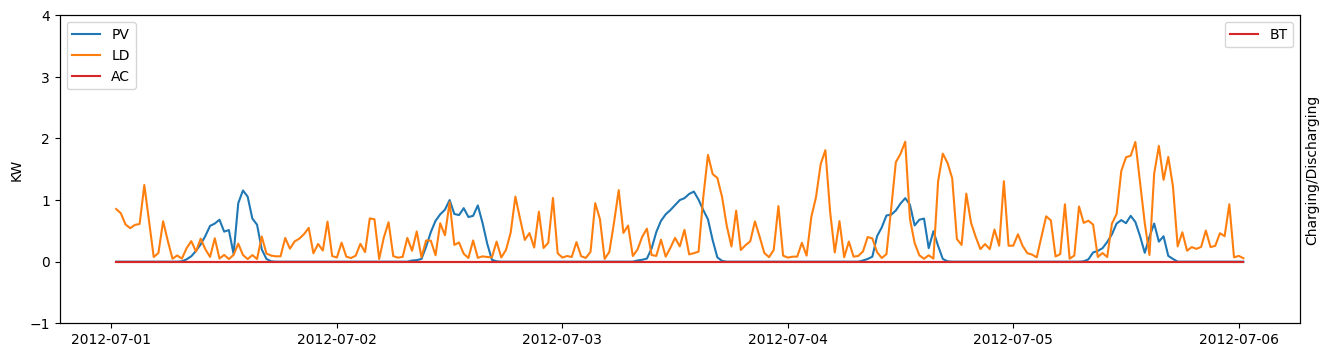

In [122]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

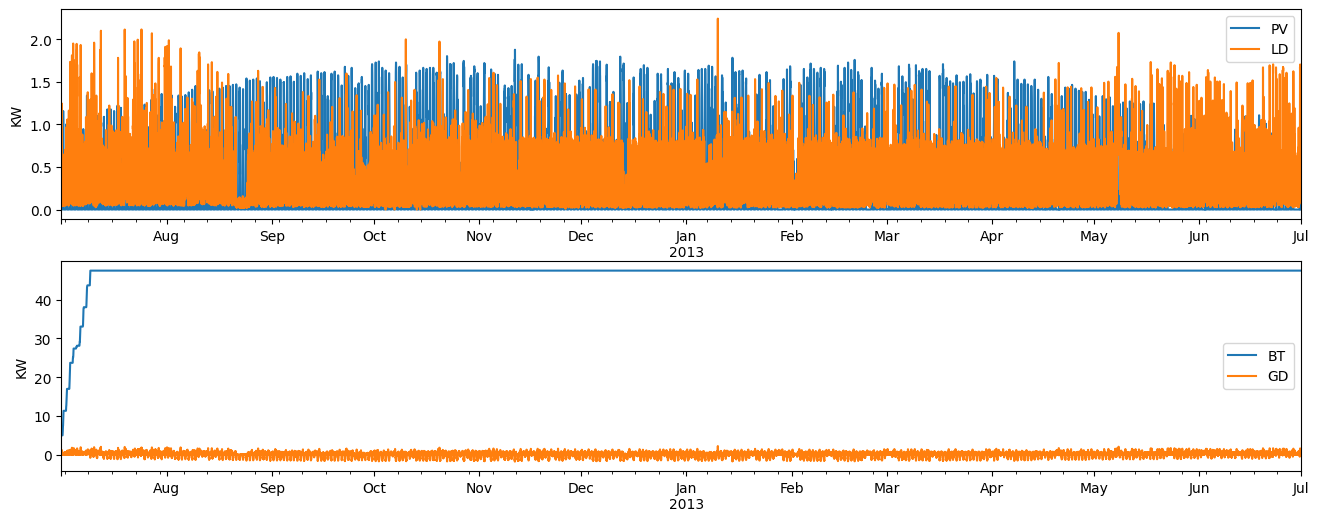

In [123]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [124]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

5115.207006187178 KW
5279.884002253413 KW
4021.2440011289436
-3814.0670004425338
SC : 0.2543670283863058
SS : 0.2464334453539752


[    0.             0.             0.         ... -3814.06700044
 -3814.06700044 -3814.06700044]


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1472/1945581510.py:8: RuntimeWarning: invalid value encountered in divide
  ss =  (c_pv + c_ex) / c_pv


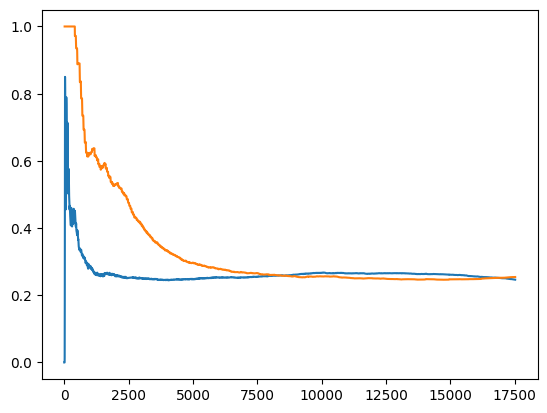

In [125]:
c_pv = np.cumsum(df_out['PV'].values)
c_ld = np.cumsum(df_out['LD'].values)
c_ex = df_out['GD'].values
c_ex[c_ex > 0] = 0
c_ex = np.cumsum(c_ex)

sc =  (c_pv + c_ex) / c_ld
ss =  (c_pv + c_ex) / c_pv

sc[np.isnan(sc)] = 0
print(c_ex)
# plt.plot(c_pv)
# plt.plot(c_ld)
# plt.plot(c_ex)
plt.plot(sc)
plt.plot(ss)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>